## File created by Reid Wyde


### Last updated 11.4.19


# Data Driven Growth Models for Combination Therapy for HER2+ Breast Cancer

## Traversing differential equations parameter space using Markov Chain Monte Carlo

#### Background: Chemotherapy (Doxorubicin) and immunotherapy (Trastuzumab/Herceptin) were given to adult female rats previously injected with HER2+ breast cancer [ ]. Trastuzumab is understood to improve vascular regularization within tumors and improve chemotherapy efficacy [ ]. This project investigates growth models for HER2+ cancer in the presence of different combinations of Doxorubicin and Trastuzumab. The goal is to deliver a data validated growth model that informs optimal treatment using these therapies, as well as characterize the tumoral system, including the relationship between tumor size, natural growth rate, drug clearing rate, and magnitude of drug effect.

### Mathematical models of tumor growth and simulation visualizations provided by Dr. Ernesto Lima, Associate Researcher at The Center for Computational Oncology at The University of Texas, 2019. 

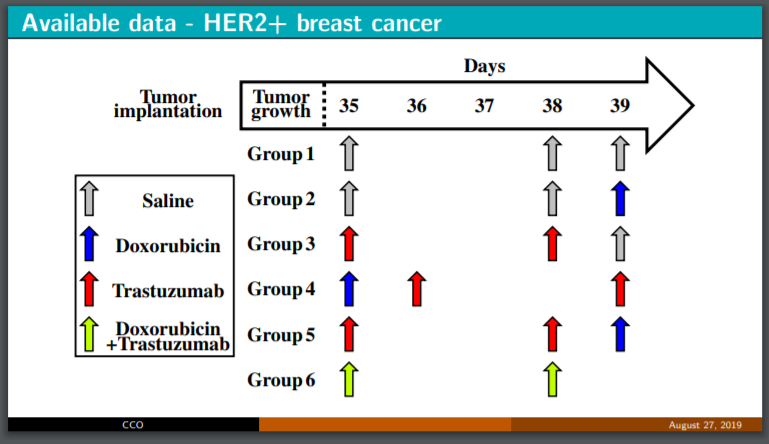

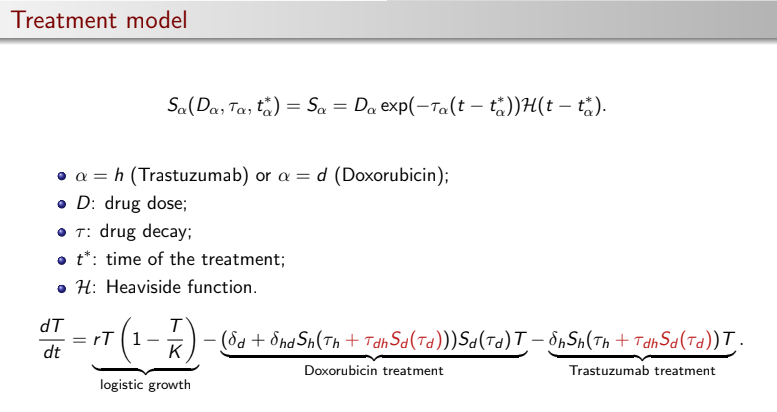

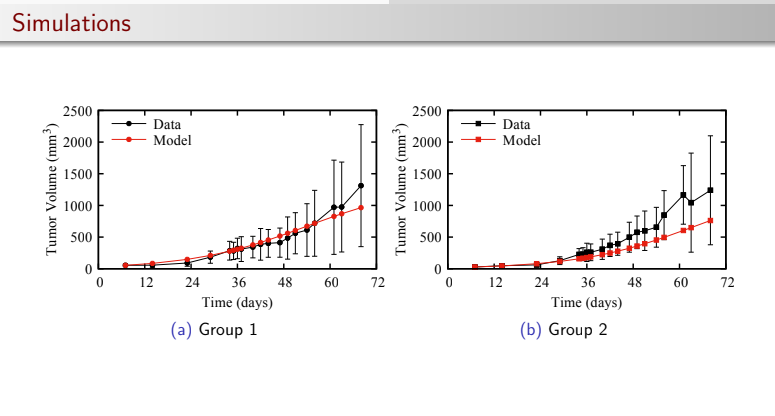

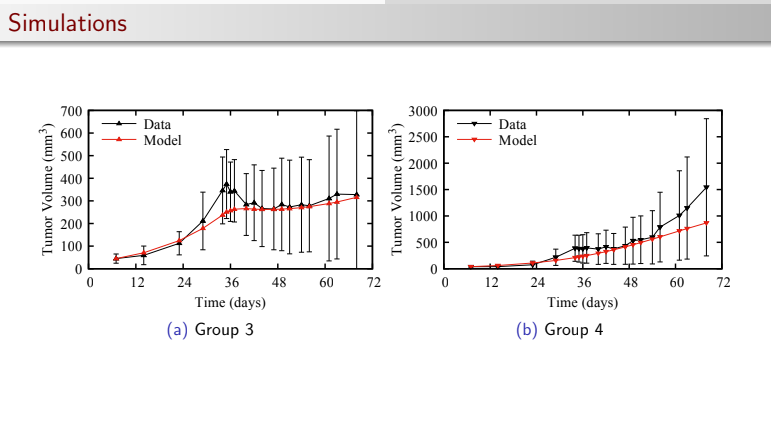

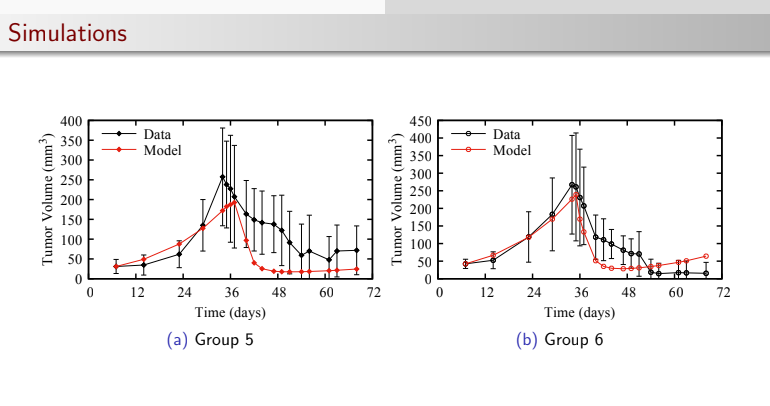

Simulation Parameters found: 

        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03

## Note: From here on, groups will be 0 indexed. i.e. group 0 is the control, group 5 is the simultaneous combination therapy

## General Strategy:  We will fit parameters one group at a time. Group 0 will parameterize the natural growth rate of cancer. Group 1 will parameterize Doxorubicin in isolation. Group 2 will parameterize Herceptin (Trastuzumab) in isolation. Groups 3, 4, and 5 will parameterize the drug-drug interaction. 


## This greedy strategy is motivated by the understanding that MCMC doesn't converge effectively for large dimensionality, models tend to get stuck. 

## New Model Iteration: Multiple Differential Equations

### Until now, we have considered the HER2+ cancer system as a single differential equation. We will now hypothesize that the system can be parameterized by multiple ODEs. 

### We will parameterize two different systems. The first system will be comprised of three differential equations. These equations will describe tumor growth, effective doxorubicin presence, and effective herceptin presence in the cancer system. 

### System 1:

$$ \frac{dT}{dt} = ( r - \delta_D D - \delta_{DH} D H - \delta_H H ) T  $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D $$

$$ or $$ 
$$ \frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H $$



With $S_h$ and $S_D$ being considered in this model as the Kronecker delta function, occuring $\epsilon$ time after the days of treatment listed, since those datapoints were taken before treatment was given on those days.

### System 2: 

We consider the pharmacodynamics and cell signalling pathway that doxorubicin and herceptin affect. Doxorubicin has been known to increase radically oxidizing species (ROS, or 'free radicals'), e.g. quinones or ketones, and herceptin is known to supress NRF2, which is a signalling molecule that curtails the effects and amount of free radicals in the cell.  


We will consider effective free radical concentration as a latent variable, with tumor size being directly effected by the free radical concentration, and the free radical concentration being effected by both doxorubicin and herceptin. We will also consider that herceptin has immune signalling properties independent of the free radical production mechanism, and can thus affect tumor size independently of doxorubicin. We choose $O$ for the radically oxidizing species variable to avoid confusion with tumor growth rate $r$.



$$ \frac{dT}{dt} = (r - \delta_{HO} H O - \delta_H H ) T $$


$$ \frac{dO}{dt} = \delta_{DO} D - \tau_O O $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D $$

$$ or $$ 

$$ \frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H $$







# Code

In [102]:
#visualization
import matplotlib.pyplot as plt

#arrays
import numpy as np

#file system
import os
import platform

#CSV read
import pandas as pd

#model building
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

np.random.seed(123)

In [103]:
pm.__file__

'C:\\Users\\Reid\\Anaconda3\\lib\\site-packages\\pymc3\\__init__.py'

In [104]:
if platform.system() == 'Windows':  # check the file system formatting
    filename = os.getcwd() + '\..\data\\tumor_size_db.csv'
else:
    filename = os.getcwd() + '/../data//tumor_size_db.csv'
    
tumor_size_db = pd.read_csv(filename)
#tumor_size_db.head()

In [105]:
ts = np.array(tumor_size_db['Day']).transpose() # dimension: (19,)
Ts = np.array(tumor_size_db[['G1_avg','G2_avg','G3_avg','G4_avg','G5_avg','G6_avg']]).transpose() # indexing: group, time
sigmas = np.array(tumor_size_db[['G1_sd','G2_sd','G3_sd','G4_sd','G5_sd','G6_sd']]).transpose()

In [106]:
def get_tt(tuple_treatment_group):
    switcher={
        ('dox',1): [39],
        
        ('her',2): [35,38],
        
        ('dox',3): [35],
        ('her',3): [36,39],
        
        ('her',4): [35,38],
        ('dox',4): [39],
        
        ('her',5): [35,38],
        ('dox',5): [35,38]
    }  
    return switcher.get(tuple_treatment_group, [])

## Treatment concentration model - decaying exponential

In [107]:
def get_Sd(tau_d, t):
    Sd = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('dox',group))
        for tt in treatment_times:
            Sd[group] = Sd[group] + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh(tau_h, tau_dh, Sd, t):
    Sh = np.zeros((6,))
    for group in range(6):
        treatment_times = get_tt(('her',group))
        for tt in treatment_times:
            tau = tau_h + tau_dh*Sd            
            # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
            # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
            # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
            Sh[group] = Sh[group] + np.nan_to_num(np.exp(-tau[group]*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh


def get_Sd_by_group(tau_d, t, group): 
    Sd = 0
    treatment_times = get_tt(('dox',group))
    for tt in treatment_times:
        Sd = Sd + np.exp(-tau_d*(t-tt))*np.heaviside(t-tt, 0)
    return Sd

def get_Sh_by_group(tau_h, tau_dh, Sd, t, group):
    Sh = 0
    treatment_times = get_tt(('her',group))
    for tt in treatment_times:
        tau = tau_h + tau_dh*Sd            
        # We run into a problem when we calculate the exponential term. It can sometimes hit a numerical singularity
        # the singularity occurs between dox treatment and her treatment, and saturates the representation of the fp in python
        # I have patched this by doing a nam_to_num conversion, which will cast the value to the highest fp number, and it will then be multiplied by 0, which should solve the problem
        Sh = Sh + np.nan_to_num(np.exp(-tau*(t-tt)))*np.heaviside(t-tt, 0) 
    return Sh




## Treatment concentration model - impulse

In [108]:
def get_Sd_impulse(ts):
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('dox', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Sds[group, ii] = 1
    return Sds
    

def get_Sh_impulse(ts):
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        treatment_times = get_tt(('her', group))
        for tt in treatment_times:
            ii = np.where(ts > tt)[0][0]
            Shs[group, ii] = 1
    return Shs


def get_Sd_impulse_by_group(ts, group):
    Sds = np.zeros((1, len(ts)))
    treatment_times = get_tt(('dox', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Sds[0, ii] = 1
    return Sds
    
def get_Sh_impulse_by_group(ts, group):
    Shs = np.zeros((1, len(ts)))
    treatment_times = get_tt(('her', group))
    for tt in treatment_times:
        ii = np.where(ts > tt)[0][0]
        Shs[0, ii] = 1
    return Shs





### Treatment calculation unit tests

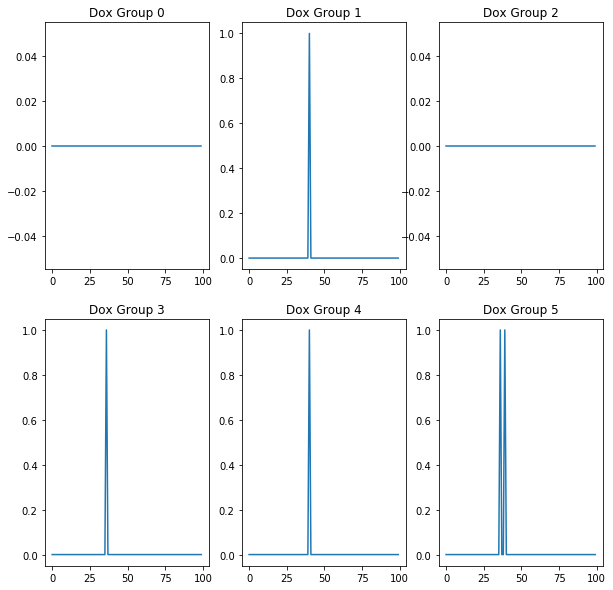

In [109]:
"""
def test_treatment_Sd():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd()
"""

def test_treatment_Sd_impulse():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = get_Sd_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd_impulse()




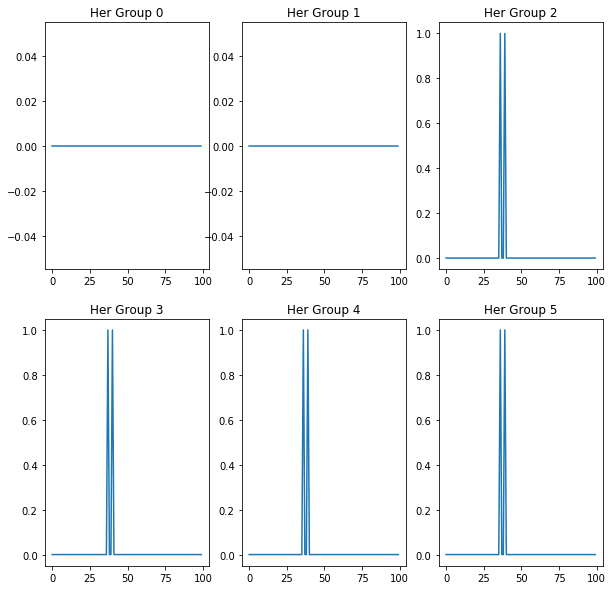

In [110]:
"""
def test_treatment_Sh():
    tau_h=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        Sds[:,ii] = get_Sd(tau_d, ts[ii])
        Shs[:,ii] = get_Sh(tau_h, tau_dh, Sds[:,ii], ts[ii])
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh()

"""



def test_treatment_Sh_impulse():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = get_Sh_impulse(ts)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh_impulse()


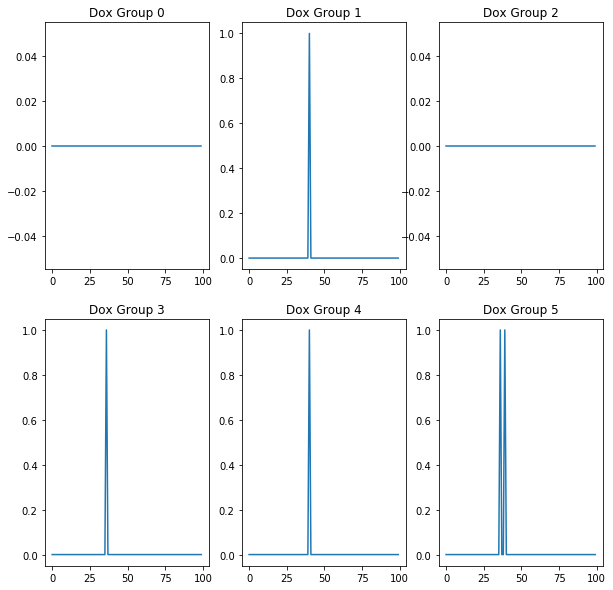

In [111]:
"""def test_treatment_Sd_by_group():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for ii in range(len(ts)):
        for jj in range(6):
            Sds[jj,ii] = get_Sd_by_group(tau_d, ts[ii], jj)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return

test_treatment_Sd_by_group()

"""

def test_treatment_Sd_impulse_by_group():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Sds = np.zeros((6, len(ts)))
    for group in range(6):
        Sds[group,:] = get_Sd_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Dox Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Sds[group])
    plt.show()
    return


test_treatment_Sd_impulse_by_group()



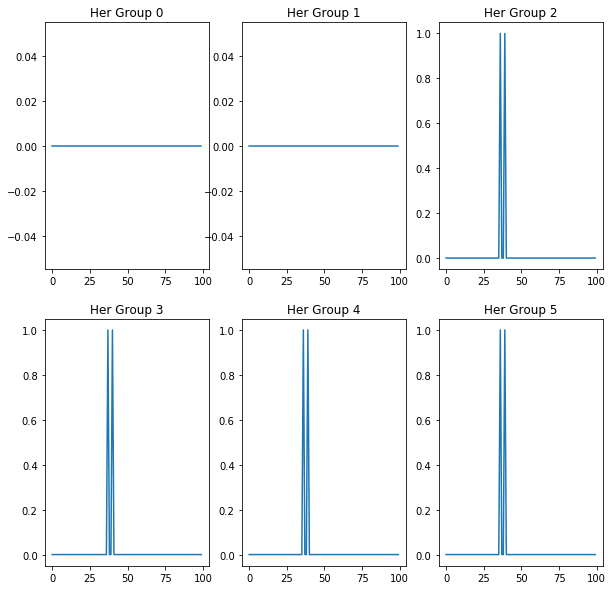

In [112]:
"""
def test_treatment_Sh_by_group():
    tau_h=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    Sds = np.zeros((6, len(ts)))
    tau_dh = 0
    tau_d = 0
    for ii in range(len(ts)):
        for jj in range(6):
            Sds[jj,ii] = get_Sd_by_group(tau_d, ts[ii], jj)
            Shs[jj,ii] = get_Sh_by_group(tau_h, tau_dh, Sds[jj,ii], ts[ii], jj)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return

test_treatment_Sh_by_group()

"""

def test_treatment_Sh_impulse_by_group():
    tau_d=0.1
    ts = np.array([int(x) for x in np.linspace(0,99,100)])
    Ts = np.ones(ts.shape)
    Shs = np.zeros((6, len(ts)))
    for group in range(6):
        Shs[group,:] = get_Sh_impulse_by_group(ts, group)
    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    for group in range(6):
        axs[int(group/3), int(group%3)].title.set_text('Her Group ' + str(group))
        axs[int(group/3), int(group%3)].plot(ts, Shs[group])
    plt.show()
    return


test_treatment_Sh_impulse_by_group()




## Simulation Graphing Methods

In [113]:
sim_times = np.linspace(7,70,100*(70-7+1)) # original time indexing started at day 7

def graph_sim_by_group(sim_times, T_sim, group):
    plt.figure(figsize=[4,2.5])
    plt.scatter(ts, Ts[group,:])
    plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
    plt.plot(sim_times, T_sim)
    plt.title('Group ' + str(group))
    plt.xlabel('Day')
    plt.ylabel('Size')
    plt.show()
    
def graph_sim(sim_times, T_sim):
    plt.figure(figsize=[16,10])
    for group in range(6):
        plt.subplot(2,3,group+1)
        plt.scatter(ts, Ts[group,:])
        plt.errorbar(ts, Ts[group,:], sigmas[group,:],fmt='.',capsize=2)
        plt.plot(sim_times, T_sim[group,:])
        plt.title('Group ' + str(group))
        plt.xlabel('Day')
        plt.ylabel('amt')
    plt.show()

## Forward DE Models

In [114]:
def rungeKutta_multidimensional(ts, T0, dTdt, params): 
    time_len = len(ts.ravel())
    ret = np.zeros((len(T0), time_len))
    ret[:,0] = T0
    T = T0
    for i in range(1,time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params, i) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params, i) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params, i) 
        k4 = h * dTdt(t+h, T + k3, params, i) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        T[T<0] = 0
        ret[:,i] = T
    return ret


def rungeKutta(ts, T0, dTdt, params): 
    time_len = len(ts.ravel())
    ret = np.zeros((1, time_len))
    ret[0,0] = T0
    T = T0
    for i in range(1,time_len):
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        k1 = h * dTdt(t, T, params, i) 
        k2 = h * dTdt(t+0.5*h, T + 0.5 * k1, params, i) 
        k3 = h * dTdt(t+0.5*h, T + 0.5 * k2, params, i) 
        k4 = h * dTdt(t+h, T + k3, params, i) 
        T = T + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
        T = max(T, 0) 
        ret[0,i] = T
    return ret


def D_rungeKutta(ts, Sds, dHdt, params):
    time_len = len(ts.ravel())
    ret = np.zeros((1, time_len))
    ret[0,0] = 0
    D = 0
    for i in range(1,time_len):
        #D = max(D, 0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        Sd = Sds[0,i]
        k1 = h * dHdt(t, D, params, Sd) 
        k2 = h * dHdt(t+0.5*h, D + 0.5 * k1, params, Sd) 
        k3 = h * dHdt(t+0.5*h, D + 0.5 * k2, params, Sd) 
        k4 = h * dHdt(t+h, D + k3, params, Sd) 
        D = D + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        D = max(D, 0)
        ret[0,i] = D
    return ret

def H_rungeKutta(ts, Shs, dHdt, params):
    time_len = len(ts.ravel())
    ret = np.zeros((1, time_len))
    ret[0,0] = 0
    H = 0
    for i in range(1,time_len):
        #H = max(H, 0)
        t0 = ts[i-1]
        t = ts[i]
        h = t-t0 
        Sh = Shs[0,i]
        k1 = h * dHdt(t, H, params, Sh) 
        k2 = h * dHdt(t+0.5*h, H + 0.5 * k1, params, Sh) 
        k3 = h * dHdt(t+0.5*h, H + 0.5 * k2, params, Sh) 
        k4 = h * dHdt(t+h, H + k3, params, Sh) 
        H = H + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4) 
        H = max(H, 0)
        ret[0,i] = H
    return ret



## Growth Model Class

In [115]:
class growth_model(object):
    def __init__(self, times, T0):
        self._times = times
        self._T0 = T0

    def _simulate(self, params, times):
        if self.group_num in [2, 3, 4, 5]:
            self.Shs = get_Sh_impulse_by_group(times, self.group_num)
            self.Hs = H_rungeKutta(times, self.Shs, self.dHdt, params)
        if self.group_num in [1, 3, 4, 5]:
            self.Sds = get_Sd_impulse_by_group(times, self.group_num)
            self.Ds = D_rungeKutta(times, self.Sds, self.dDdt, params)
        T_values = rungeKutta(times, self._T0, self.dTdt, params)
        return T_values
   
    def get_param(self, param_name, n=10):
        return pm.summary(self.trace)['mean'][param_name]

## Logistic Growth Model
### Used to fit to group 0 data

In [116]:
class growth_model_natural(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[0,0])
        self.group_num = 0
    
    def simulate(self, r, K, times=None):
        if times is None: times = self._times        
        return self._simulate([r, K], times)
    
    def dTdt(self, t, T, params, i):
        r, K = [x for x in params] 
        return T*r*(1-(T/K))
    
    def backward(self):
        T_obs = Ts[0,:]
        sigmas_obs = sigmas[0,:]/100
        
        with pm.Model():
            self.param_list = ['r', 'K']
            r_lower = 0.0
            r_upper = 0.1
            K_lower = 0.0
            K_upper = 20000
            
            r = pm.Uniform('r', lower=r_lower, upper=r_upper)
            K = pm.Uniform('K', lower=K_lower, upper=K_upper)

            ## Theano wrapper is necessary in order to pass the forward evolution to PyMC3
            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(r, K):
                th_states = self.simulate(r, K)
                return th_states
            
            forward = th_forward_model(r, K)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 10 # more is better. This is how the MCMC calculation is easily distributed between cores
            startsmc=[{'r':np.random.uniform(r_lower, r_upper), 
                       'K':np.random.uniform(K_lower, K_upper),                     
                      } for _ in range(n_chains)]
            num_samples = 200 # longer is better. Within each chain, operations are sequential and cannot be parallelized.
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace)
            
            
            
    def fit_sim_graph_model():
        this_model = growth_model_natural()
        this_model.backward()
        r, K = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(r, K, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 0)
        print('r: ' + str(r))
        print('K: ' + str(K))

        return r, K


            
#r, K = growth_model_natural.fit_sim_graph_model()

r = 0.05509
K = 7161

### Dr. Ernesto Lima's Findings, for reference

r = 6.773495e-02

K = 1.331254e+03

## There might not be enough logistic behavior in group 0 to parameterize K. 

## Herceptin Treatment


$$ \frac{dT}{dt} = ( r - \delta_D D - \delta_{DH} D H - \delta_H H ) T  $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D $$

$$ or $$ 
$$ \frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H $$

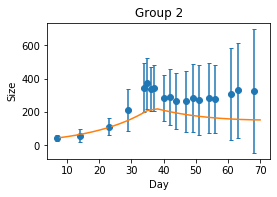

delta_h: 4
tau_h: 0.01


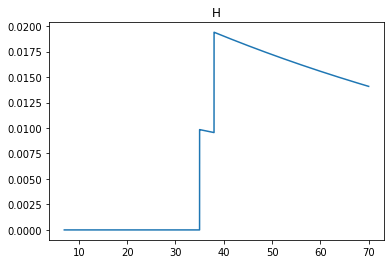

In [117]:
class growth_model_her(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[2,0])
        self.group_num = 2
    
    def simulate(self, delta_h, tau_h, times=None):
        if times is None: times = self._times
        return self._simulate([delta_h, tau_h], times)
    
    def dHdt(self, t, H, params, Sh):
        delta_h, tau_h = [x for x in params]
        return Sh - tau_h*H

    def dTdt(self, t, T, params, i):
        delta_h, tau_h  = [x for x in params] 
        H = self.Hs[0,i]
        return (r - delta_h*H)*T
    
    def backward(self):
        T_obs = Ts[2,:]
        sigmas_obs = sigmas[2,:]
        with pm.Model():
            self.param_list = ['delta_h', 'tau_h']
            
            delta_h_lower = 3.99
            delta_h_upper = 4
            
            tau_h_lower = 0.039
            tau_h_upper = 0.04
            
            delta_h = pm.Uniform('delta_h', lower=delta_h_lower, upper=delta_h_upper)
            tau_h = pm.Uniform('tau_h', lower=tau_h_lower, upper=tau_h_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_h, tau_h):
                th_states = self.simulate(delta_h, tau_h)
                return th_states
            
            forward = th_forward_model(delta_h, tau_h)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(100)
            n_chains = 5
            startsmc=[{'delta_h':np.random.uniform(delta_h_lower, delta_h_upper),
                       'tau_h':np.random.uniform(tau_h_lower, tau_h_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 200
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def fit_sim_graph_model():
        this_model = growth_model_her()
        this_model.backward()
        delta_h, tau_h = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_h, tau_h, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        print('delta_h: ' + str(delta_h))
        print('tau_h: ' + str(tau_h))
        
        plt.figure()
        plt.plot(sim_times.ravel(), this_model.Hs.ravel())
        plt.title('H')
        plt.show()

        return delta_h, tau_h
        #return
        
    def sim_graph_model():
        this_model = growth_model_her()
        delta_h = 4
        tau_h = 0.01
        T_sim = this_model.simulate(delta_h, tau_h, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 2)
        print('delta_h: ' + str(delta_h))
        print('tau_h: ' + str(tau_h))
        
        plt.figure()
        plt.plot(sim_times.ravel(), this_model.Hs.ravel())
        plt.title('H')
        plt.show()

        return delta_h, tau_h
    

            
#delta_h, tau_h = growth_model_her.fit_sim_graph_model()
delta_h, tau_h = growth_model_her.sim_graph_model()



## Doxorubicin treatment

$$ \frac{dT}{dt} = ( r - \delta_D D - \delta_{DH} D H - \delta_H H ) T  $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D $$

$$ or $$ 
$$ \frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H $$


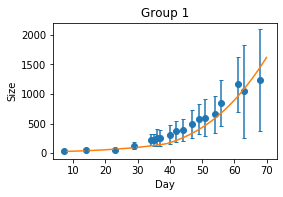

delta_d: -5
tau_d: 0.05


(-5, 0.05)

In [139]:
class growth_model_dox(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[1,0])
        self.group_num = 1
    
    def simulate(self, delta_d, tau_d, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_d, tau_d], times)
    
    def dDdt(self, t, D, params, Sd):
        delta_d, tau_d = [x for x in params]
        return Sd - tau_d*D
    
    def dTdt(self, t, T, params, i):
        delta_d, tau_d = [x for x in params]
        #get_Sd_by_group(tau_d, t, group)
        #Sd = get_Sd_time_delay_by_group(tau_d, t, 1)
        D = self.Ds[0,i]
        return (r*(1 - (T/K)) - delta_d*D)*T
    
    def backward(self):
        T_obs = Ts[1,:]
        sigmas_obs = sigmas[1,:]
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = 0 
            delta_d_upper = 1
            
            tau_d_lower = 2
            tau_d_upper = 20
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 10
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 500
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
            
    def fit_sim_graph_model():
        this_model = growth_model_dox()
        this_model.backward()
        delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_d, tau_d, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 1)

        print('delta_d: ' + str(delta_d))
        print('tau_d: ' + str(tau_d))

        return delta_d, tau_d
    
    def sim_graph_model():
        this_model = growth_model_dox()
        delta_d = -5
        tau_d = 0.05
        T_sim = this_model.simulate(delta_d, tau_d, sim_times)
        graph_sim_by_group(sim_times, T_sim.reshape(-1,1), 1)

        print('delta_d: ' + str(delta_d))
        print('tau_d: ' + str(tau_d))

        return delta_d, tau_d

            
#delta_d, tau_d = growth_model_dox.fit_sim_graph_model()

growth_model_dox.sim_graph_model()



## Combinational Therapy

$$ \frac{dT}{dt} = ( r - \delta_D D - \delta_{DH} D H - \delta_H H ) T  $$


$$ \frac{dH}{dt} = S_H - \tau_H H - \tau_{DH} D H $$


$$ \frac{dD}{dt} = S_D - \tau_D D $$

$$ or $$ 
$$ \frac{dD}{dt} = S_D - \tau_D D + \tau_{HD} H $$

In [ ]:
class growth_model_dd_interaction(growth_model):
    
    def __init__(self):
        super().__init__(ts, Ts[3:6,0])    
    
    def _simulate(self, params, times):
        self.Shs = get_Sh_impulse_by_group(times, self.group_num)
        self.Hs = H_rungeKutta(times, self.Shs, self.dHdt, params)
        self.Sds = get_Sd_impulse_by_group(times, self.group_num)
        self.Ds = H_rungeKutta(times, self.Sds, self.dDdt, params)
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, delta_dh, tau_dh, times=None):
        if times is None: times = self._times        
        return self._simulate([delta_dh, tau_dh], times)
    
    def dDdt(self, t, D, params, Sd):
        return Sd - tau_d*D
    
    def dHdt(self, t, H, D, params, Sh):
        delta_dh, tau_dh = [x for x in params]
        return Sh - tau_h*H - tau_dh*D*H
    
    def dTdt(self, t, T, params, i):
        delta_dh, tau_dh = [x for x in params]
        D = self.Ds[i]
        H = self.Hs[i] 
        return  (r - delta_d*D - delta_dh*D*H - delta_h*H)*T
    
    def backward(self):
        T_obs = Ts[3:6,:]
        sigmas_obs = sigmas[3:6,:]
        with pm.Model():
            self.param_list = ['delta_dh', 'tau_dh']
            delta_dh_lower = 0
            delta_dh_upper = 20
            tau_dh_lower = 0
            tau_dh_upper = 5

            delta_dh = pm.Uniform('delta_dh', lower=delta_dh_lower, upper=delta_dh_upper)
            tau_dh = pm.Uniform('tau_dh', lower=tau_dh_lower, upper=tau_dh_upper)
            

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_dh, tau_dh):
                th_states = self.simulate(delta_dh, tau_dh)
                return th_states
            
            forward = th_forward_model(delta_dh, tau_dh)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas_obs, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 5
            startsmc=[{'delta_dh':np.random.uniform(delta_dh_lower, delta_dh_upper),
                       'tau_dh':np.random.uniform(tau_dh_lower, tau_dh_upper),   
                      } for _ in range(n_chains)]
            num_samples = 300
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            
    
    def fit_sim_graph_model():
        this_model = growth_model_dd_interaction()
        this_model.backward()
        delta_dh, tau_dh = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(delta_dh, tau_dh, sim_times)
        graph_sim_by_group(sim_times, T_sim[0,:].reshape(-1,1), 3)
        graph_sim_by_group(sim_times, T_sim[1,:].reshape(-1,1), 4)
        graph_sim_by_group(sim_times, T_sim[2,:].reshape(-1,1), 5)

        print('delta_dh: ' + str(delta_d))
        print('tau_dh: ' + str(tau_d))

        return delta_d, tau_d

            
delta_dh, tau_dh = growth_model_dd_interaction.fit_sim_graph_model()

## Dr. Ernesto Lima's findings, for reference

delta_dh = 4.327301e-01

tau_dh = 9.344758e+03

## My findings

In [26]:
print('r = ' + str(r))
print('K = ' + str(K))
print('delta_d = ' + str(delta_d))
print('tau_d = ' + str(tau_d))
print('delta_h = ' + str(delta_h))
print('tau_h = ' + str(tau_h))
print('delta_dh = ' + str(delta_dh))
print('tau_dh = ' + str(tau_dh))

r = 0.05497774464293899
K = 9816.093043121215
delta_d = 0.4852846336158916
tau_d = 11.955202058486714
delta_h = 0.03201949799686409
tau_h = 1.4030314559965114
delta_dh = 0.4852846336158916
tau_dh = 11.955202058486714


## Simulate parameters found by Dr. Lima


Dr. Lima's Parameters

r = 6.773495e-02
k = 1.331254e+03
delta_h = 3.165840e-02
tau_h = 1.696031e-02
delta_d = 6.548050e-05
tau_d = 3.001805e-01
delta_dh = 4.327301e-01
tau_dh = 9.344758e+03




New Params



## modified tau_dh, original model

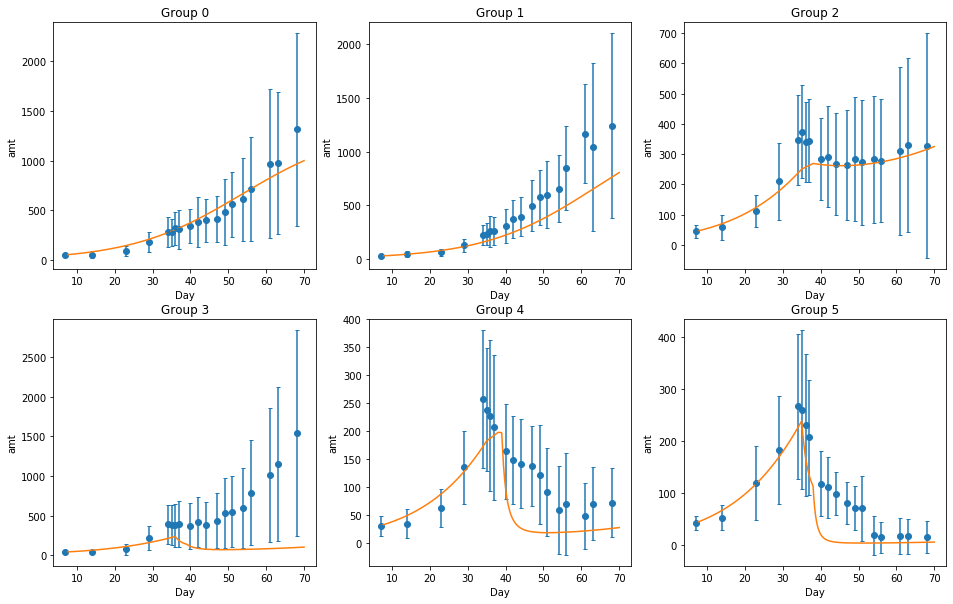

In [28]:
class growth_model_Lima(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times
        params = [6.773495e-02, 1.331254e+03, 3.165840e-02, 1.696031e-02, 6.548050e-05, 3.001805e-01,\
                  4.327301e-01, 9.344758e-03] #9.344758e+03]
        return self._simulate(params, times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        
        """
        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03
        #tau_dh = 9.344758e-03
        """
        
        r, K, delta_h, tau_h, delta_d, tau_d, delta_dh, tau_dh = [x for x in params]

        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        ret =  T*(r*(1-(T/K)) - (delta_d + delta_dh * Sh)*Sd - delta_h*Sh)
    
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
    def sim_graph_model():
        this_model = growth_model_Lima()
        #this_model.backward()
        #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(sim_times)
        graph_sim(sim_times, T_sim)
        
        return T_sim

T_sim = growth_model_Lima.sim_graph_model()


## Original parameters, original model

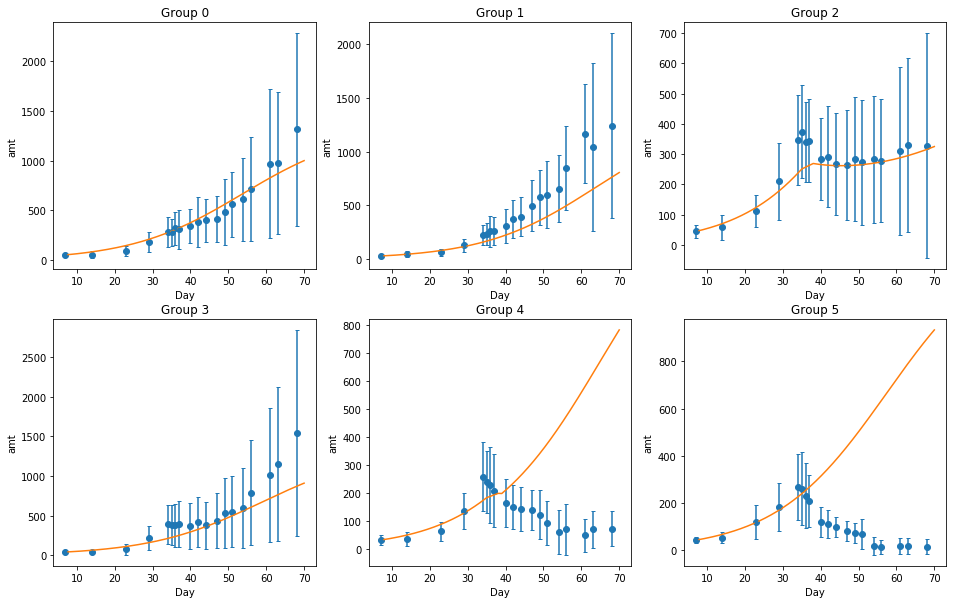

In [30]:
class growth_model_Lima(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times
        params = [6.773495e-02, 1.331254e+03, 3.165840e-02, 1.696031e-02, 6.548050e-05, 3.001805e-01,\
                  4.327301e-01, 9.344758e+03]
        return self._simulate(params, times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        
        """
        r = 6.773495e-02
        K = 1.331254e+03
        delta_h = 3.165840e-02
        tau_h = 1.696031e-02
        delta_d = 6.548050e-05
        tau_d = 3.001805e-01
        delta_dh = 4.327301e-01
        tau_dh = 9.344758e+03
        #tau_dh = 9.344758e-03
        """
        
        r, K, delta_h, tau_h, delta_d, tau_d, delta_dh, tau_dh = [x for x in params]

        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        ret =  T*(r*(1-(T/K)) - (delta_d + delta_dh * Sh)*Sd - delta_h*Sh)
    
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
    def sim_graph_model():
        this_model = growth_model_Lima()
        #this_model.backward()
        #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(sim_times)
        graph_sim(sim_times, T_sim)
        
        return T_sim

T_sim = growth_model_Lima.sim_graph_model()


## new parameters

par_r = 5.477366e-02
par_k = 8.150373e+03

par_dt = 2.056754e-02 // delta tras
par_tt = 1.207568e-03 // tau tras

par_dd = 9.202416e-07 // delta doxo
par_td = 2.880215e-03 // tau doxo

par_del_td = 6.328250e-02 delta tras->doxo
par_tau_dt = 1.922454e+03 tau delta->doxo



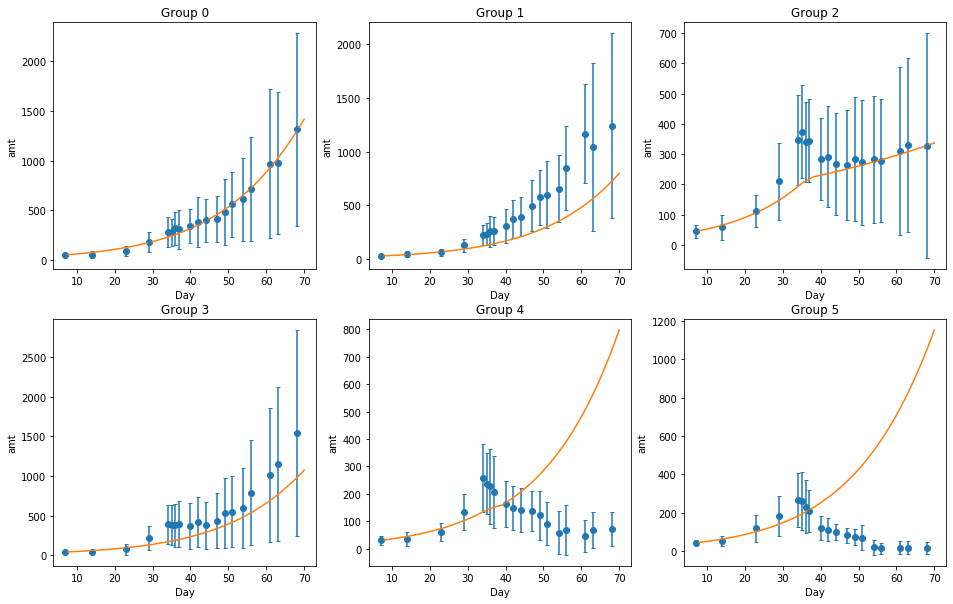

In [34]:
class growth_model_Lima_2(growth_model):
    def __init__(self):
        super().__init__(ts, Ts[:,0])
        return
    
    def _simulate(self, params, times):
        values = rungeKutta_multidimensional(times, self._T0, self.dTdt, params)
        return values
    
    def simulate(self, times=None):
        if times is None: times = sim_times
        params = [5.477366e-02, 8.150373e+03, 2.056754e-02, 1.207568e-03, 9.202416e-07, 2.880215e-03, \
                   6.328250e-02, 1.922454e+03]
        #tau_dh = 1.922454e+03
        return self._simulate(params, times)
    
    def dTdt(self, t, T, params):
        #delta_d, tau_d = [x for x in params] 
        #Sd = get_Sd_group2(tau_d, t)
        
        """
        r = 5.477366e-02
        K = 8.150373e+03
        delta_h = 2.056754e-02
        tau_h = 1.207568e-03
        delta_d = 9.202416e-07
        tau_d = 2.880215e-03
        delta_dh = 6.328250e-02
        tau_dh = 1.922454e+03
        """
        
        r, K, delta_h, tau_h, delta_d, tau_d, delta_dh, tau_dh = [x for x in params]

        Sd = get_Sd(tau_d, t)
        Sh = get_Sh(tau_h, tau_dh, Sd, t)
    
        ret =  T*(r*(1-(T/K)) - (delta_d + delta_dh * Sh)*Sd - delta_h*Sh)
    
        return ret
    
    """
    def backward(self):
        T_obs = Ts_dox
        sigmas = sigmas_dox
        with pm.Model():
            self.param_list = ['delta_d', 'tau_d']
            
            delta_d_lower = -5
            delta_d_upper = 5 
            
            tau_d_lower = -5
            tau_d_upper = 5
            
            delta_d = pm.Uniform('delta_d', lower=delta_d_lower, upper=delta_d_upper)
            tau_d = pm.Uniform('tau_d', lower=tau_d_lower, upper=tau_d_upper)

            @as_op(itypes=[tt.dscalar, tt.dscalar], otypes=[tt.dmatrix]) 
            def th_forward_model(delta_d, tau_d):
                th_states = self.simulate(delta_d, tau_d)
                return th_states
            
            forward = th_forward_model(delta_d, tau_d)
            
            T = pm.Normal('T', mu=forward, sigma = sigmas, observed=T_obs)

            # Initial points for each of the chains
            np.random.seed(123)
            n_chains = 4
            startsmc=[{'delta_d':np.random.uniform(delta_d_lower, delta_d_upper),
                       'tau_d':np.random.uniform(tau_d_lower, tau_d_upper),                  
                      } for _ in range(n_chains)]
            num_samples = 2000
            num_tune = int(num_samples/5)
            step = pm.Slice()
            self.trace = pm.sample(num_samples, step=step, tune=num_tune, chains = n_chains, cores=1, start=startsmc)
            pm.traceplot(self.trace) 
            return
        """
    def sim_graph_model():
        this_model = growth_model_Lima_2()
        #this_model.backward()
        #delta_d, tau_d = [this_model.get_param(x) for x in this_model.param_list]
        T_sim = this_model.simulate(sim_times)
        graph_sim(sim_times, T_sim)
        
        return T_sim

T_sim = growth_model_Lima_2.sim_graph_model()
